In [1]:
# Clone the YOLO repository
!git clone https://github.com/ultralytics/ultralytics.git
%cd ultralytics

# Install requirements
#!pip install -r requirements.txt
!pip install ultralytics


Cloning into 'ultralytics'...
remote: Enumerating objects: 56572, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 56572 (delta 91), reused 33 (delta 33), pack-reused 56401 (from 2)
Receiving objects: 100% (56572/56572), 31.89 MiB | 24.29 MiB/s, done.
Resolving deltas: 100% (41869/41869), done.
/content/ultralytics
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
from ultralytics import YOLO
import pandas as pd
import os
from PIL import Image
import shutil

# Update this path to your dataset folder in Google Drive
base_path = "/content/drive/MyDrive/Lion/Images"
splits = ['train', 'test', 'valid']

# === STEP 1: Collect unique classes ===
all_classes = set()
for split in splits:
    csv_path = os.path.join(base_path, split, "_annotations.csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        all_classes.update(df['class'].unique())

classes = sorted(list(all_classes))
class_to_id = {cls: i for i, cls in enumerate(classes)}
print("✅ Classes found:", class_to_id)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Classes found: {'Bracelet': 0, 'Chair': 1, 'Dog': 2, 'Flag': 3, 'Other Shoes': 4, 'Person': 5, 'Sneakers': 6, 'Soccer': 7}


In [8]:
# === STEP 2: Convert CSV annotations to YOLO format ===
for split in splits:
    print(f"\n🔄 Processing {split} set...")

    csv_path = os.path.join(base_path, split, "_annotations.csv")
    images_dir = os.path.join(base_path, split)

    output_images_dir = os.path.join(base_path, "images", split)
    output_labels_dir = os.path.join(base_path, "labels", split)

    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)

    df = pd.read_csv(csv_path)

    for image_name in df['filename'].unique():
        image_path = os.path.join(images_dir, image_name)
        label_path = os.path.join(output_labels_dir, image_name.replace('.jpg', '.txt'))

        try:
            img = Image.open(image_path)
            w, h = img.size
        except Exception as e:
            print(f"❌ Could not open {image_name}: {e}")
            continue

        shutil.copy(image_path, os.path.join(output_images_dir, image_name))

        img_df = df[df['filename'] == image_name]

        with open(label_path, 'w') as f:
            for _, row in img_df.iterrows():
                try:
                    cls_id = class_to_id[row['class']]
                except KeyError:
                    continue

                x_center = ((row['xmin'] + row['xmax']) / 2) / w
                y_center = ((row['ymin'] + row['ymax']) / 2) / h
                width = (row['xmax'] - row['xmin']) / w
                height = (row['ymax'] - row['ymin']) / h
                f.write(f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    print(f"✅ Done with {split}")



🔄 Processing train set...
✅ Done with train

🔄 Processing test set...
✅ Done with test

🔄 Processing valid set...
✅ Done with valid


In [9]:
yaml_path = os.path.join(base_path, "mfc.yaml")
with open(yaml_path, "w") as f:
    f.write(f"train: {base_path}/images/train\n")
    f.write(f"val: {base_path}/images/valid\n\n")
    f.write(f"nc: {len(classes)}\n")
    f.write("names: [\n")
    f.write(",\n".join(f"  '{cls}'" for cls in classes))
    f.write("\n]")

print(f"✅ YAML written to: {yaml_path}")


✅ YAML written to: /content/drive/MyDrive/Lion/Images/mfc.yaml


In [10]:
model = YOLO('yolov3.pt')  # Loads pretrained YOLOv3

model.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    batch=8,
    name='yolov3_mfc_custom'
)



PRO TIP 💡 Replace 'model=yolov3.pt' with new 'model=yolov3u.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 198M/198M [00:01<00:00, 120MB/s]


Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov3.pt, data=/content/drive/MyDrive/Lion/Images/mfc.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov3_mfc_custom, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

100%|██████████| 755k/755k [00:00<00:00, 24.5MB/s]

Overriding model.yaml nc=80 with nc=8

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 1]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     37056  ultralytics.nn.modules.block.Bottleneck      [64, 64]                      
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    295680  ultralytics.nn.modules.block.Bottleneck      [128, 128]                    
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  8   4724736  ultralytics.nn.modules.block.Bottleneck      [256, 256]                    
  7                  -1  1   1180672  ultralytics

  8                  -1  8  18886656  ultralytics.nn.modules.block.Bottleneck      [512, 512]                    
  9                  -1  1   4720640  ultralytics.nn.modules.conv.Conv             [512, 1024, 3, 2]             
 10                  -1  4  37761024  ultralytics.nn.modules.block.Bottleneck      [1024, 1024]                  
 11                  -1  1   9440256  ultralytics.nn.modules.block.Bottleneck      [1024, 1024, False]           
 12                  -1  1    525312  ultralytics.nn.modules.conv.Conv             [1024, 512, 1, 1]             
 13                  -1  1   4720640  ultralytics.nn.modules.conv.Conv             [512, 1024, 3, 1]             
 14                  -1  1    525312  ultralytics.nn.modules.conv.Conv             [1024, 512, 1, 1]             
 15                  -1  1   4720640  ultralytics.nn.modules.conv.Conv             [512, 1024, 3, 1]             
 16                  -2  1    131584  ultralytics.nn.modules.conv.Conv             [512,

100%|██████████| 5.35M/5.35M [00:00<00:00, 96.7MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.7±0.5 ms, read: 14.5±14.7 MB/s, size: 59.1 KB)


train: Scanning /content/drive/MyDrive/Lion/Images/labels/train... 175 images, 0 backgrounds, 0 corrupt: 100%|██████████| 175/175 [00:01<00:00, 145.98it/s]

train: New cache created: /content/drive/MyDrive/Lion/Images/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 26.8±12.6 MB/s, size: 67.0 KB)


val: Scanning /content/drive/MyDrive/Lion/Images/labels/valid... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 63.76it/s]

val: New cache created: /content/drive/MyDrive/Lion/Images/labels/valid.cache


Plotting labels to /content/ultralytics/runs/detect/yolov3_mfc_custom/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 84 weight(decay=0.0), 91 weight(decay=0.0005), 90 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/ultralytics/runs/detect/yolov3_mfc_custom
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.93G      1.193      2.223       1.27        146        640: 100%|██████████| 22/22 [00:13<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         20        296      0.667      0.478      0.402      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.56G      1.214      1.207      1.255        106        640: 100%|██████████| 22/22 [00:12<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         20        296      0.467      0.337       0.35      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.83G       1.24        1.2      1.293         88        640: 100%|██████████| 22/22 [00:12<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         20        296     0.0959      0.346      0.134     0.0992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.98G       1.26      1.252      1.265        105        640: 100%|██████████| 22/22 [00:12<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         20        296      0.385      0.403      0.417      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.98G      1.383       1.31      1.342        152        640: 100%|██████████| 22/22 [00:12<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         20        296      0.566      0.362      0.424      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.92G      1.361      1.336      1.397        165        640: 100%|██████████| 22/22 [00:12<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         20        296        0.6      0.387       0.46      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.85G      1.326      1.235      1.312        113        640: 100%|██████████| 22/22 [00:12<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         20        296      0.438       0.47      0.484      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.99G      1.314      1.157      1.313        152        640: 100%|██████████| 22/22 [00:13<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         20        296      0.584      0.393       0.47      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.96G      1.283      1.115      1.305        105        640: 100%|██████████| 22/22 [00:13<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         20        296      0.592      0.369      0.438      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.79G      1.241      1.076      1.252        100        640: 100%|██████████| 22/22 [00:13<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         20        296      0.591      0.371      0.443      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.05G      1.231      1.007      1.258        174        640: 100%|██████████| 22/22 [00:13<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

                   all         20        296      0.558       0.47      0.463      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       7.8G      1.196      1.007      1.234        128        640: 100%|██████████| 22/22 [00:13<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         20        296      0.598      0.483      0.466      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.85G      1.206     0.9594      1.268        129        640: 100%|██████████| 22/22 [00:13<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         20        296      0.578      0.481      0.489      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.84G      1.131     0.9029      1.191        141        640: 100%|██████████| 22/22 [00:13<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         20        296      0.545      0.468      0.463      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.88G      1.104     0.8843      1.192        104        640: 100%|██████████| 22/22 [00:13<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

                   all         20        296      0.398      0.437       0.46      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.84G      1.109     0.8263      1.156        158        640: 100%|██████████| 22/22 [00:13<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         20        296      0.415      0.459      0.469      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.84G      1.104     0.8691      1.177        148        640: 100%|██████████| 22/22 [00:13<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         20        296      0.426      0.482      0.473      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.79G      1.097     0.8925      1.207        150        640: 100%|██████████| 22/22 [00:13<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         20        296      0.757      0.394       0.45       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.83G      1.045     0.8064      1.161        121        640: 100%|██████████| 22/22 [00:13<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         20        296      0.779      0.383      0.468      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       7.8G      1.055     0.8088       1.14        182        640: 100%|██████████| 22/22 [00:13<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         20        296      0.617      0.496      0.482      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.81G      1.035     0.7765      1.142         95        640: 100%|██████████| 22/22 [00:13<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         20        296      0.638      0.488      0.547      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.82G      1.061     0.8186      1.171         91        640: 100%|██████████| 22/22 [00:13<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         20        296      0.634      0.471      0.491      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.01G      1.039     0.7947      1.165        167        640: 100%|██████████| 22/22 [00:13<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         20        296      0.606      0.454      0.478      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.81G      1.014      0.772      1.133        167        640: 100%|██████████| 22/22 [00:13<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         20        296      0.475      0.431      0.479      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.79G      1.059     0.8011      1.177        118        640: 100%|██████████| 22/22 [00:13<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         20        296      0.462      0.568      0.495      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.83G     0.9735     0.7042      1.105         93        640: 100%|██████████| 22/22 [00:13<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         20        296      0.571      0.482       0.49      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.05G     0.9806     0.7246      1.124        122        640: 100%|██████████| 22/22 [00:13<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         20        296      0.626      0.492      0.485      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.77G     0.9378     0.6767      1.096        117        640: 100%|██████████| 22/22 [00:13<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         20        296      0.643      0.491      0.506       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       7.8G     0.9569     0.6818      1.096        208        640: 100%|██████████| 22/22 [00:13<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

                   all         20        296      0.638      0.498      0.543      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.82G     0.9187     0.6792      1.093        156        640: 100%|██████████| 22/22 [00:13<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         20        296       0.63      0.493      0.551      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.89G     0.9011     0.6576      1.085        134        640: 100%|██████████| 22/22 [00:13<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         20        296      0.627      0.486      0.525      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.81G      0.888     0.6327      1.062        165        640: 100%|██████████| 22/22 [00:13<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

                   all         20        296       0.65      0.564       0.52      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.81G     0.9068     0.6563      1.095         91        640: 100%|██████████| 22/22 [00:13<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         20        296      0.747      0.531       0.56      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.95G     0.8881     0.6209      1.068        303        640: 100%|██████████| 22/22 [00:13<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         20        296      0.583      0.546      0.519      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.86G     0.8797     0.6054      1.058        135        640: 100%|██████████| 22/22 [00:13<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         20        296      0.755      0.526      0.543      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.84G     0.8553     0.6266      1.065        168        640: 100%|██████████| 22/22 [00:13<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         20        296      0.682      0.565      0.556      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.79G     0.8528     0.6088      1.065        154        640: 100%|██████████| 22/22 [00:13<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         20        296      0.718       0.58      0.556      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.79G     0.8479     0.6133      1.058        118        640: 100%|██████████| 22/22 [00:13<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         20        296       0.84      0.482      0.498      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.97G     0.8444     0.5813      1.043        167        640: 100%|██████████| 22/22 [00:13<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         20        296       0.84      0.488      0.522      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.79G     0.7957     0.5608      1.016         55        640: 100%|██████████| 22/22 [00:13<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         20        296      0.782      0.546      0.558      0.401


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.84G     0.7538     0.5144     0.9586         75        640: 100%|██████████| 22/22 [00:13<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         20        296      0.764       0.55      0.554      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.78G     0.7529     0.5083      0.949         81        640: 100%|██████████| 22/22 [00:13<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         20        296      0.814      0.489      0.556      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.95G     0.7075      0.471     0.9317         93        640: 100%|██████████| 22/22 [00:13<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         20        296      0.758      0.596      0.555        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       7.8G     0.7392     0.4694     0.9489         79        640: 100%|██████████| 22/22 [00:13<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         20        296      0.736      0.588      0.567       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.78G     0.7405     0.4916     0.9547         96        640: 100%|██████████| 22/22 [00:13<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         20        296      0.753      0.577      0.574       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       7.8G     0.7125      0.456     0.9375         54        640: 100%|██████████| 22/22 [00:14<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         20        296      0.766      0.564      0.573      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.02G     0.7175     0.4544     0.9442        114        640: 100%|██████████| 22/22 [00:13<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         20        296      0.771      0.561      0.569      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.78G     0.6921     0.4292     0.9238         87        640: 100%|██████████| 22/22 [00:13<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         20        296      0.763      0.564      0.574      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.79G     0.6863     0.4255      0.923        141        640: 100%|██████████| 22/22 [00:13<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         20        296      0.768      0.566      0.572      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       7.8G     0.6808     0.4302     0.9204        114        640: 100%|██████████| 22/22 [00:13<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         20        296      0.765      0.573      0.571      0.408



50 epochs completed in 0.311 hours.
Optimizer stripped from /content/ultralytics/runs/detect/yolov3_mfc_custom/weights/last.pt, 207.8MB
Optimizer stripped from /content/ultralytics/runs/detect/yolov3_mfc_custom/weights/best.pt, 207.8MB

Validating /content/ultralytics/runs/detect/yolov3_mfc_custom/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv3 summary (fused): 96 layers, 103,670,408 parameters, 0 gradients, 282.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


                   all         20        296      0.771      0.561      0.568      0.417
              Bracelet          4          4          1          0          0          0
                  Flag          3          3      0.882      0.333      0.345      0.242
           Other Shoes         13         58      0.418       0.31      0.326      0.137
                Person         20        102      0.834      0.931      0.959      0.779
              Sneakers         18        111      0.631      0.847       0.84      0.554
                Soccer         17         18      0.862      0.944      0.937      0.789
Speed: 0.3ms preprocess, 30.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/ultralytics/runs/detect/yolov3_mfc_custom


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 3, 4, 5, 6, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e6abf8458d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

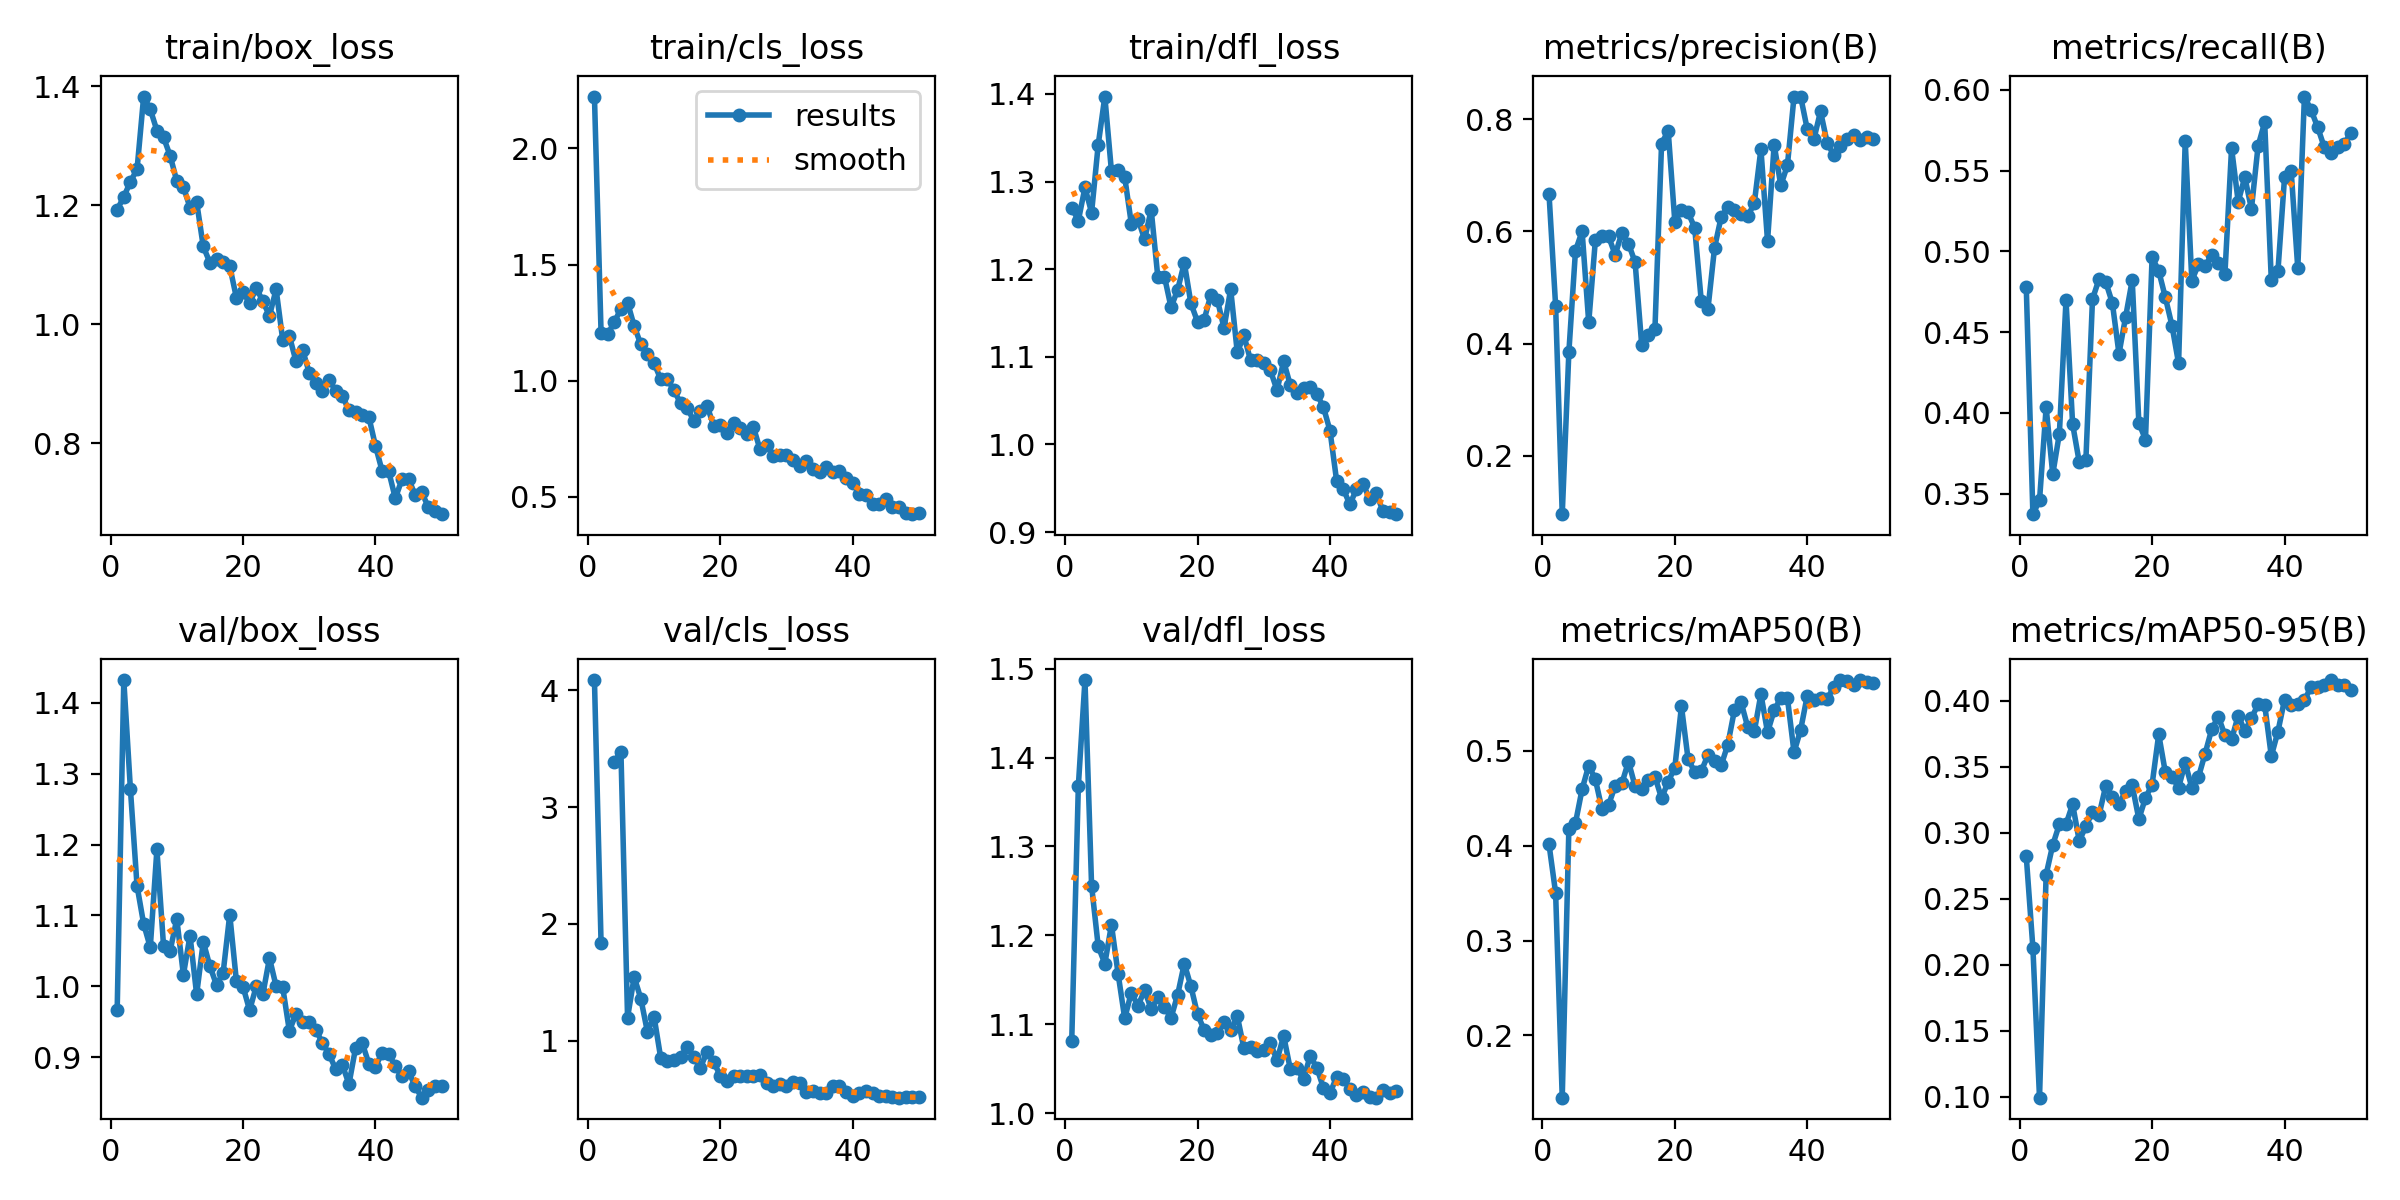

In [43]:
from IPython.display import Image
Image(filename='runs/detect/yolov3_mfc_custom/results.png')


In [36]:
import os
from ultralytics import YOLO

# Paths
images_folder = '/content/drive/MyDrive/Lion/Images/train'
model_path = 'runs/detect/yolov3_mfc_custom/weights/best.pt'
output_folder = '/content/drive/MyDrive/Lion/Inference_Results'

# Load model
model = YOLO(model_path)

# Run prediction on the whole folder
results = model.predict(
    source=images_folder,    # folder with images
    save=True,               # save predicted images
    project=output_folder,   # base directory to save results
    name='yolov3_preds',     # subfolder name
    exist_ok=True            # overwrite if exists
)

print(f"✅ All results saved to: {output_folder}/yolov3_preds/")



image 1/175 /content/drive/MyDrive/Lion/Images/train/objects365_v1_00065839_jpg.rf.550b15793cadcca28bb87d46349d8f5b.jpg: 640x640 1 Other Shoes, 4 Persons, 6 Sneakerss, 1 Soccer, 110.1ms
image 2/175 /content/drive/MyDrive/Lion/Images/train/objects365_v1_00079620_jpg.rf.d10fcda5acb378d451a062f848e547b9.jpg: 640x640 2 Persons, 5 Sneakerss, 74.6ms
image 3/175 /content/drive/MyDrive/Lion/Images/train/objects365_v1_00243547_jpg.rf.be17b6f32fc90a6572661c910de262c6.jpg: 640x640 7 Persons, 7 Sneakerss, 61.5ms
image 4/175 /content/drive/MyDrive/Lion/Images/train/objects365_v1_00262385_jpg.rf.a5b262e03aa357b4468aecc12e61ee27.jpg: 640x640 1 Other Shoes, 6 Persons, 4 Sneakerss, 58.8ms
image 5/175 /content/drive/MyDrive/Lion/Images/train/objects365_v1_00274170_jpg.rf.82dfc6e89f02376e1bd2a0ca00f7fb94.jpg: 640x640 4 Persons, 4 Sneakerss, 1 Soccer, 59.3ms
image 6/175 /content/drive/MyDrive/Lion/Images/train/objects365_v1_00320080_jpg.rf.3119ae2168876bc660bf7876e05d5ace.jpg: 640x640 4 Persons, 4 Sneake

In [13]:
import os
from ultralytics import YOLO

# Define input and output folders
input_folder = f"{base_path}/test"
output_folder = "/content/drive/MyDrive/Lion/Images/test/predictions"

# Make sure output directory exists
os.makedirs(output_folder, exist_ok=True)

# Load the model
model = YOLO('runs/detect/yolov3_mfc_custom/weights/best.pt')

# Loop through all image files
for image_name in os.listdir(input_folder):
    image_path = os.path.join(input_folder, image_name)

    # Check for image files only
    if not image_path.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')):
        print(f"Skipping non-image file: {image_name}")
        continue

    # Run inference and automatically save to the output folder
    model(image_path, save=True, project=output_folder, name='', exist_ok=True)
    print(f"Processed and saved: {image_name}")

print("✅ All images processed.")



image 1/1 /content/drive/MyDrive/Lion/Images/test/objects365_v2_01374417_jpg.rf.dee270971bb0e40293c629a50bcfa59c.jpg: 640x640 4 Other Shoess, 5 Persons, 3 Sneakerss, 1 Soccer, 77.3ms
Speed: 2.8ms preprocess, 77.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/MyDrive/Lion/Images/test/predictions/predict
Processed and saved: objects365_v2_01374417_jpg.rf.dee270971bb0e40293c629a50bcfa59c.jpg

image 1/1 /content/drive/MyDrive/Lion/Images/test/objects365_v2_01965066_jpg.rf.210fb07eebab6c942dd3c1c8a136b320.jpg: 640x640 5 Other Shoess, 7 Persons, 3 Sneakerss, 1 Soccer, 66.1ms
Speed: 1.9ms preprocess, 66.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/MyDrive/Lion/Images/test/predictions/predict
Processed and saved: objects365_v2_01965066_jpg.rf.210fb07eebab6c942dd3c1c8a136b320.jpg

image 1/1 /content/drive/MyDrive/Lion/Images/test/objects365_v2_00991150_jpg.rf.07906a073fa673ad29203c63512


image 1/1 /content/drive/MyDrive/Lion/Images/test/objects365_v2_01170246_jpg.rf.204fb2922d0950651a1cda6995e37b5f.jpg: 640x640 4 Persons, 4 Sneakerss, 1 Soccer, 79.5ms
Speed: 3.5ms preprocess, 79.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


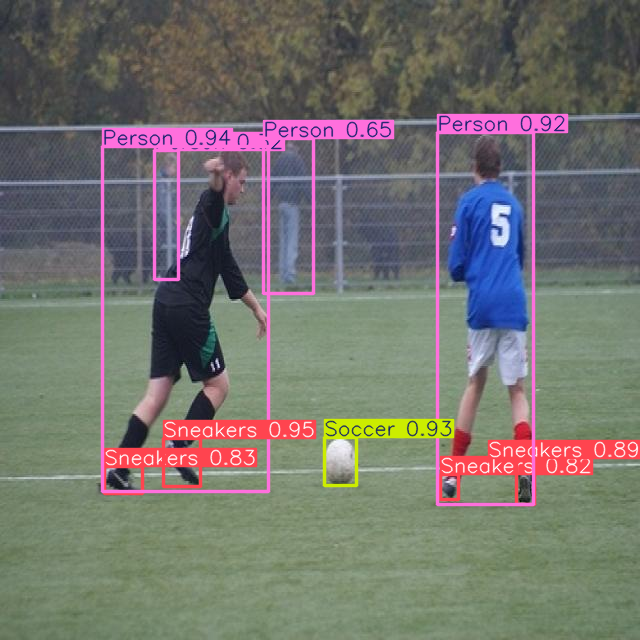

In [14]:
image_path = f"{base_path}/test/objects365_v2_01170246_jpg.rf.204fb2922d0950651a1cda6995e37b5f.jpg"

model = YOLO('runs/detect/yolov3_mfc_custom/weights/best.pt')
results = model(image_path)

# Loop through each result and show it
for result in results:
    result.show()   # Display prediction
    result.save()   # Save prediction


In [12]:
metrics = model.val()
print("📊 Metrics:", metrics)


Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 31.7±17.1 MB/s, size: 75.0 KB)


val: Scanning /content/drive/MyDrive/Lion/Images/labels/valid.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


                   all         20        296      0.773      0.562      0.572      0.417
              Bracelet          4          4          1          0          0          0
                  Flag          3          3      0.883      0.333      0.345      0.242
           Other Shoes         13         58      0.416      0.308      0.337      0.143
                Person         20        102      0.844      0.941      0.968      0.782
              Sneakers         18        111      0.633      0.847      0.841      0.545
                Soccer         17         18      0.862      0.944       0.94      0.793
Speed: 7.2ms preprocess, 54.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to /content/ultralytics/runs/detect/val
📊 Metrics: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 3, 4, 5, 6, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e6abea

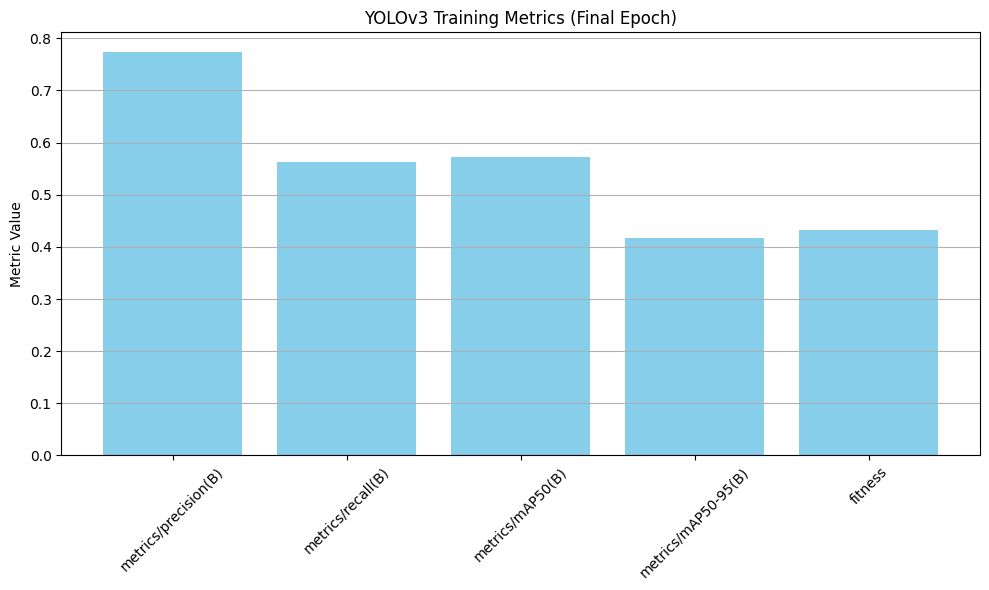

In [16]:
import matplotlib.pyplot as plt

# Extract the metrics dictionary
results_dict = metrics.results_dict

# Plot the key metrics
plt.figure(figsize=(10, 6))
plt.bar(results_dict.keys(), [float(v) for v in results_dict.values()], color='skyblue')
plt.ylabel("Metric Value")
plt.title("YOLOv3 Training Metrics (Final Epoch)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [44]:
from google.colab import files
files.download('runs/detect/yolov3_mfc_custom/weights/best.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>